# Aerial Image Segmentation with PyTorch
Create train function and evaluator for training loop

Use U-Net architecture for segmentation

## Task 1 setup colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 33.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=319ad7ee005e7b18bf6eb273f211ac9a025bc58a717c0491e4ba5321975a4418
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=b7375e1453ebfb62c5afa226864391a30e6d3ae5843d9ec2d7d3d475cce2ffe5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6s9fs8g1
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6s9fs8g1
   

Here the dataset which we are going to use in this project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500x1500 pixels in size, covering an area of 2.25 square kilometers.

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

In [3]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 28.45 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Task 2 Configurations

In [32]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 8
LR = 0.003
EPOCHS = 5

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
idx = 2

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.


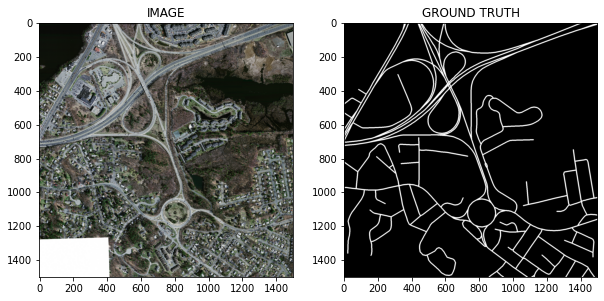

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=13)
len(train_df), len(valid_df)

(159, 40)

## Task 3 Augmentation functions
albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
  ])

def valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])

## Task 4 Create custom dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegData(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # (h, w, c)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)# (h, w)
    mask = np.expand_dims(mask, axis=-1) # (h, w, c)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # dict type
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # (c, h, w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.
    mask = torch.round(torch.Tensor(mask) / 255.)

    return image, mask

In [15]:
trainset = SegData(train_df, train_augs())
validset = SegData(valid_df, valid_augs())


In [16]:
print(f"size of trainset: {len(trainset)}")
print(f"size of validset: {len(validset)}")

size of trainset: 159
size of validset: 40


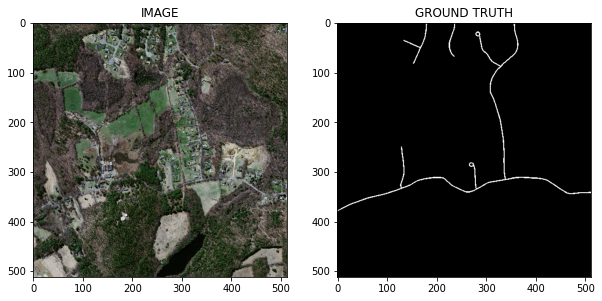

In [17]:
idx = 3

image, mask = trainset[idx]

helper.show_image(image, mask)

## Task 5 Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
print(f"total number of batches in trainloader: {len(trainloader)}")
print(f"total number of batches in validloader: {len(validloader)}")

total number of batches in trainloader: 20
total number of batches in validloader: 5


In [21]:
for image, mask in trainloader:
  break

print(f"shape of image: {image.shape}")
print(f"shape of mask: {mask.shape}")


shape of image: torch.Size([8, 3, 512, 512])
shape of mask: torch.Size([8, 1, 512, 512])


## Task 6 Create a segmentation model
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn


In [23]:
class SegModel(nn.Module):

  def __init__(self):
    super(SegModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None: # mask=None when testing time
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits


In [25]:
model = SegModel()
model.to(DEVICE);

## Task 7 Create train and validation function

In [28]:
def train_fn(dataloader, model, optimizer):
  model.train() # dropout on
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images, masks = images.to(DEVICE), masks.to(DEVICE)

    logits, loss = model(images, masks)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

def eval_fn(dataloader, model):
  model.eval() # dropout off
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images, masks = images.to(DEVICE), masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(dataloader)

## Task 8 Train the model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [34]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("MODEL SAVED.")
    best_loss = valid_loss

  print(f"Epoch: {i+1}, train loss: {train_loss}, valid loss: {valid_loss}")



100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


MODEL SAVED.
Epoch: 1, train loss: 0.5710986360907555, valid loss: 0.6441912651062012


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch: 2, train loss: 0.5707414627075196, valid loss: 0.6470518827438354


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


MODEL SAVED.
Epoch: 3, train loss: 0.5733621999621391, valid loss: 0.6198929786682129


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


MODEL SAVED.
Epoch: 4, train loss: 0.5669652044773101, valid loss: 0.5885175943374634


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

Epoch: 5, train loss: 0.5590088292956352, valid loss: 0.6359440684318542


## Task 9 Inference

In [35]:
idx = np.random.randint(0, len(validset))

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (bs, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0 # if greater than 0.5 then consider as 1.0




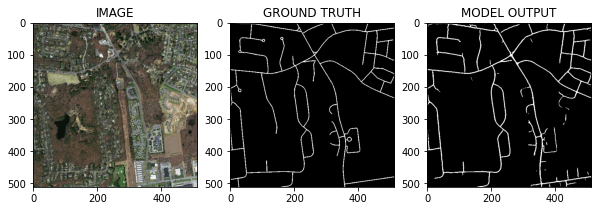

In [36]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))